# Data Understanding

In [1]:
# load necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import librosa

In [2]:
# read training data

train_df = pd.read_csv("../data/train.csv")
print("number of rows:", train_df.shape)

print("head of this table")
train_df.head(10)


number of rows: (106800, 15)
head of this table


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [5]:
# number of eeg_ids
train_df['eeg_id'].unique().shape

(17089,)

In [38]:
# sanity check on eeg_id
c = 0
for _ in range(1000):
    _eeg_id = train_df['eeg_id'].sample(1).values[0]
    _path = f"../data/train_eegs/{_eeg_id}.parquet"
    if os.path.exists(_path):
        c+=1
print(c)

1000


In [40]:
# null values
train_df.isna().sum(axis=0)

eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
expert_consensus                    0
seizure_vote                        0
lpd_vote                            0
gpd_vote                            0
lrda_vote                           0
grda_vote                           0
other_vote                          0
dtype: int64

In [41]:
train_df['spectrogram_id'].unique().shape

(11138,)

In [51]:
# sanity check for each eeg_id map with single spectrogram id
all(train_df.groupby(['eeg_id']).apply(lambda rows: rows.shape[0] == rows['spectrogram_id'].value_counts()).values)

/var/folders/dh/spbnf_1x66d4dqc724pmgy780000gp/T/ipykernel_90547/85362382.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all(train_df.groupby(['eeg_id']).apply(lambda rows: rows.shape[0] == rows['spectrogram_id'].value_counts()).values)


True

In [144]:
# sanity check: check for each eeg_id has unique spectrogram_id or not
#The relationship between spectogram_ids and eeg_id is 1:M? 
# For example, 1 spectogram may have multiple eegs but 1 eeg is always "inside" 1 spectogram

train_df.groupby(['eeg_id']).apply(lambda x: x['spectrogram_id'].unique()[0]).value_counts().iloc[:10]

/var/folders/dh/spbnf_1x66d4dqc724pmgy780000gp/T/ipykernel_90547/2794698663.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df.groupby(['eeg_id']).apply(lambda x: x['spectrogram_id'].unique()[0]).value_counts().iloc[:10]


764146759     107
1863712617     62
1940415234     54
2060670605     54
1908433744     53
1343094925     48
2074135650     39
172731638      35
1254544437     32
2077600099     31
Name: count, dtype: int64

In [128]:
train_df[train_df['spectrogram_id'] == 1908433744].head(50).sort_values(['spectrogram_sub_id']).head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
94159,2831293048,0,0.0,1908433744,0,0.0,3442835103,17408,GPD,0,0,1,0,0,0
94160,241564268,0,0.0,1908433744,1,514.0,3405210259,17408,GPD,0,0,1,0,0,0
94161,2377642317,0,0.0,1908433744,2,915.0,835145270,17408,GPD,0,0,1,0,0,0
94162,240709424,0,0.0,1908433744,3,1029.0,421099707,17408,GPD,0,0,1,0,0,0
94163,1715933755,0,0.0,1908433744,4,1229.0,2679934544,17408,GPD,0,0,1,0,0,0


In [76]:
eeg = pd.read_parquet("../data/train_eegs/1371445416.parquet")

eeg.head(2)

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,18.33,7.70,24.129999,-1.35,-10.37,-21.02,-3.03,-12.20,49.639999,77.050003,20.59,-15.60,-6.30,22.930000,23.330000,-32.840000,-61.139999,-14.68,-11.73,1552.239990
1,6.35,9.69,30.230000,6.88,-6.01,-15.83,1.78,-6.47,52.849998,80.849998,26.33,-26.35,-5.69,26.459999,28.629999,-33.040001,-58.770000,-9.75,2.03,1420.719971


### Visualization of spectrogram

In [78]:
spec = pd.read_parquet("../data/train_spectrograms/1908433744.parquet")

In [112]:
spec.head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,2.27,3.36,4.06,4.29,10.76,15.990000,24.930000,34.860001,44.230000,...,0.11,0.12,0.10,0.11,0.13,0.08,0.08,0.10,0.14,0.12
1,3,3.03,3.56,4.53,4.77,6.59,19.190001,28.020000,42.290001,37.840000,...,0.12,0.11,0.15,0.17,0.15,0.19,0.20,0.19,0.19,0.17
2,5,5.95,6.75,6.95,8.27,13.05,30.559999,46.290001,44.439999,54.279999,...,0.12,0.09,0.09,0.07,0.14,0.19,0.21,0.25,0.18,0.14
3,7,5.12,7.09,6.75,11.16,12.78,17.020000,41.889999,40.919998,49.240002,...,0.07,0.07,0.07,0.03,0.05,0.09,0.10,0.10,0.10,0.09
4,9,3.98,5.80,6.52,9.11,11.77,17.030001,18.280001,59.709999,80.199997,...,0.09,0.08,0.11,0.08,0.07,0.08,0.08,0.08,0.07,0.05


In [120]:
spectrogram_offset_labels_seconds = 0
_spec = spec.loc[(spec.time>=spectrogram_offset_labels_seconds)&(spec.time<spectrogram_offset_labels_seconds+600),]

In [121]:
del _spec['time']

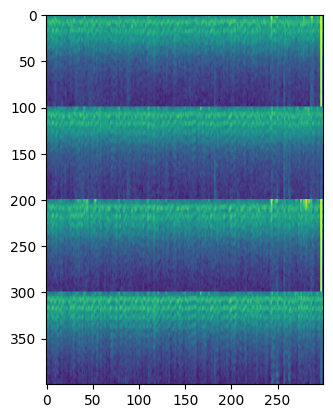

In [139]:
_spec = _spec.T
_spec = np.clip(_spec, np.exp(-4), np.exp(8))
_spec = np.log(_spec)
plt.imshow(_spec)

In [142]:
r=0
region = 0
tmp = _spec.values[r:r+300, region*100:(region+1)*100]

tmp[:, 22:-22].shape

(300, 56)

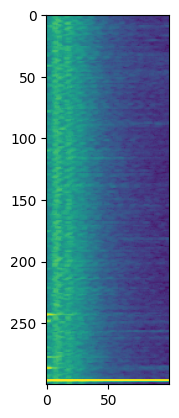

In [143]:
plt.imshow(tmp)

## Insights from kaggle discussion

- Each row of the spectrogram is represent 2 sec
- Each row of the eeg parquet is 1/200 of a second


### Does time matter?
```
Time matters for 2 reasons:

* we need time to determine what frequencies are in the signal. (i.e. without time, there is no such thing as 10Hz).
* in 3% of cases, the expert_consensus changes over time

Most people are currently ignoring the second bullet point and just assigning a single target to a single eeg_id. Later in the competition, if we use the 3% to train we can boost our CV score and LB score slightly.
```


##### references
- [EEG Understanding] https://www.youtube.com/clip/UgkxqTZZRvcuSHO4la1-qGMCpGai_VF6h-QD
- [Data Understanding] https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010
- [Inference] https://www.kaggle.com/code/alejopaullier/hms-efficientnetb0-pytorch-inference#%7C-Inference-Function-%E2%86%91

In [13]:
# code retreive the eeg and spectrogram for row
GET_ROW = 0
prefix = "../data"
EEG_PATH = f'{prefix}/train_eegs/'
SPEC_PATH = f'{prefix}/train_spectrograms/'

row = train_df.iloc[GET_ROW]

eeg = pd.read_parquet(f'{EEG_PATH}{row.eeg_id}.parquet')
eeg_offset = int( row.eeg_label_offset_seconds )
eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]

spectrogram = pd.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
spec_offset = int( row.spectrogram_label_offset_seconds )
spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                     &(spectrogram.time<spec_offset+600)]

In [14]:
eeg.shape, spectrogram.shape

((10000, 20), (300, 401))

In [15]:
spectrogram = spectrogram.iloc[:, 1:].T.values

In [16]:
_spec = np.clip(spectrogram, np.exp(-4), np.exp(8))
_spec = np.log(_spec)

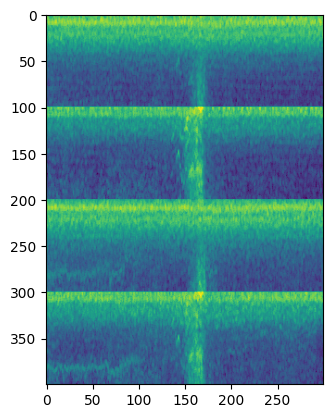

In [17]:
plt.imshow(_spec)

In [20]:
tmp = _spec.reshape(4, 100, 300)

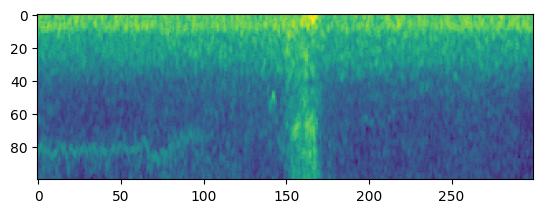

In [24]:
plt.imshow(tmp[-1])